In [32]:
# パッケージのインポート
import mysql.connector
import MySQLdb
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import time

In [33]:
objtype = "Road"

if 'df' in locals():
    del df

aspect = []

# データベース接続
connection = mysql.connector.connect(
    host = 'localhost',
    port = 3306,
    user = 'root',
    password = '',
    database = 'satreps',
)
image_type = objtype
    
objtype = "'" + objtype + "'"

"""　データベースに格納したデータを取得する。　"""
df = pd.read_sql("SELECT * FROM `seg_results` WHERE `image_type` = " + objtype, connection)
# df = pd.read_sql("SELECT * FROM `seg_results`", connection)

# aspect
for row, item in df.iterrows():
    item[1] = "'" + item[1] + "'"
    sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_type` = " + objtype + " and `image_name` = " + item[1], connection)
#     sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_name` = " + item[1], connection)

    for row, item in sql.iterrows():
        h = item[12]-item[10]
        w = item[11]-item[9]
        aspect.append([item[5], round(h/w, 1)])

columns = ('image_name', 'aspect')

aspect = pd.DataFrame(aspect, columns=columns)
del df['ID']
del df['void']
del df['image_type']

df.append(aspect)
df = pd.merge(df, aspect, on='image_name')
del df['image_name']


# ピクセル数→パーセンテージ変換
for row, item in df.iterrows():
    for i in range(len(item)-1):
        area = (item[i+1] / 262144) * 100
        df[df.columns[i+1]][row] = area
# ここまで

connection.close()

# 標準化
scaler = StandardScaler()
scaler.fit(np.array(df))
df_std = scaler.transform(np.array(df))
df_std = pd.DataFrame(df_std,columns=df.columns)


/home/tsuchiya/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 1回実行しkeysを取得後，再度実行してstepwise結果を得る

In [47]:
x = df.drop('comfortable', axis=1) # 説明変数
y = df['comfortable'] # 目的変数

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須
X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

dic = {}
keys = []

for i in range(len(result.pvalues)-1):
    dic[df.columns[i+1]]=result.pvalues[i+1]
    
# 取り除く説明変数のリスト(keys)
keys = [k for k, v in dic.items() if 0.05<v or v==np.nan]
print(keys)
for i in range(len(keys)):
    del df[keys[i]]

# 定数項(y切片)を必要とする線形回帰のモデル式ならば必須

X = sm.add_constant(x)

# 最小二乗法でモデル化
model = sm.OLS(y, X)
result = model.fit()

print(result.summary())

#vifを計算する
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
 
#vifを計算結果を出力する
print(vif)
 
#vifをグラフ化する
# plt.plot(vif["VIF Factor"])


[]
                            OLS Regression Results                            
Dep. Variable:            comfortable   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     4.576
Date:                Sun, 10 Jan 2021   Prob (F-statistic):           0.000391
Time:                        06:56:01   Log-Likelihood:                -160.02
No. Observations:                 105   AIC:                             334.0
Df Residuals:                      98   BIC:                             352.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9313      1.295     -1.491      

## KFoldによる回帰分析

In [35]:
#モジュールの読み込み
from __future__ import print_function

import pandas as pd
from pandas import Series,DataFrame

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.callbacks import ReduceLROnPlateau

# モデルの定義
from keras import models
from keras import layers
from keras import regularizers


## Import Necessary Modules
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'Mish': Mish(mish)})

## Mish Activation Function
# def mish(x):
#     return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.log(1+tf.exp(x))))(x)


## モデルの構築

In [36]:
def relu_model_rmsprop(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mae'])
    return model

def relu_model_adam(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['mae'])
    return model

def relu_model_nadam(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation='relu', input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              metrics=['mae'])
    return model


def mish_model_rmsprop(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mae'])
    return model

def mish_model_adam(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['mae'])
    return model

def mish_model_nadam(x, node):
    #ニューラルネットワークの実装①
    model = Sequential()
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation=mish, input_shape=(len(x.columns),),kernel_initializer=he_normal()))
    model.add(Dropout(0.2))
    model.add(Dense(1))
#     model.summary()
    model.compile(loss='mean_squared_error',
              optimizer=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
              metrics=['mae'])
    return model



# # このままだとグラフがみずらいので見やすくなるように修正
# def smooth_curve(points, factor = 0.9):
#     smoothed_points = []
#     for point in points:
#         if smoothed_points:
#             previous = smoothed_points[-1]
#             smoothed_points.append(previous * factor + point * (1 - factor))
#         else:
#             smoothed_points.append(point)
#     return smoothed_points


# Early Stopping
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')


In [7]:
from sklearn.model_selection import StratifiedKFold
from keras.initializers import he_normal

# k分割交差検証データの生成
"""
エポック数を100に増やし、エポックごとに検証ログを保存するようにして再訓練と検証を行う
"""

SAMPLE_DIR = "model"
 
if not os.path.exists(SAMPLE_DIR):
    # ディレクトリが存在しない場合、ディレクトリを作成する
    os.makedirs(SAMPLE_DIR)

node = 10
R_test_mse_score_list =  []
R_test_mae_score_list = []
R_smoothed_mae_history_list = []
A_test_mse_score_list =  []
A_test_mae_score_list = []
A_smoothed_mae_history_list = []
N_test_mse_score_list =  []
N_test_mae_score_list = []
N_smoothed_mae_history_list = []

RM_test_mse_score_list =  []
RM_test_mae_score_list = []
RM_smoothed_mae_history_list = []
AM_test_mse_score_list =  []
AM_test_mae_score_list = []
AM_smoothed_mae_history_list = []
NM_test_mse_score_list =  []
NM_test_mae_score_list = []
NM_smoothed_mae_history_list = []


# 処理前の時刻
t1 = time.time() 
 
while(node != 70):
    R_early_epochs = []
    A_early_epochs = []
    N_early_epochs = []
    RM_early_epochs = []
    AM_early_epochs = []
    NM_early_epochs = []

    num_epochs = 100
    R_all_mae_histories = []
    A_all_mae_histories = []
    N_all_mae_histories = []
    RM_all_mae_histories = []
    AM_all_mae_histories = []
    NM_all_mae_histories = []

    print('node #'+str(node))

    skf = StratifiedKFold(n_splits=10, shuffle = True)
    for train, test in skf.split(x, y):
        print("---------------------------------------------")
        X_train = []
        Y_train = []

        X_test = []
        Y_test = []

        #訓練データの準備
        for i in range(len(train)):
            X_train.append(df.loc[train[i]].values[1:])
            Y_train.append(df.loc[train[i]].values[0])

        X_train = np.array(X_train)

        print("訓練のQoLの内訳",Y_train.count(1),Y_train.count(2),Y_train.count(3),Y_train.count(4),Y_train.count(5))
        Y_train = np.array(Y_train)

        #検証データの準備
        for j in range(len(test)):
            X_test.append(df.loc[test[j]].values[1:])
            Y_test.append(df.loc[test[j]].values[0])

        X_test = np.array(X_test)
        X_test = pd.DataFrame(X_test)
        print("評価のQoLの内訳",Y_test.count(1),Y_test.count(2),Y_test.count(3),Y_test.count(4),Y_test.count(5))
        Y_test = pd.Series(Y_test)
#         print(X_test)
        
        
        # モデルインスタンスを取得
        R_model = relu_model_rmsprop(x, node)
        A_model = relu_model_adam(x, node)
        N_model = relu_model_nadam(x, node)
        RM_model = mish_model_rmsprop(x, node)
        AM_model = mish_model_adam(x, node)
        NM_model = mish_model_nadam(x, node)
        
        # モデルをサイレントモードで訓練と検証を実施
        R_history = R_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        R_mae_history = R_history.history['val_mean_absolute_error']
        R_all_mae_histories.append(R_mae_history)
        R_early_epochs.append(len(R_history.history['loss']))
        print("R:"+str(R_early_epochs))
        print("R:"+str(np.mean(R_early_epochs)))

        # モデルをサイレントモードで訓練と検証を実施
        A_history = A_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        A_mae_history = A_history.history['val_mean_absolute_error']
        A_all_mae_histories.append(A_mae_history)
        A_early_epochs.append(len(A_history.history['loss']))
        print("A:"+str(A_early_epochs))
        print("A:"+str(np.mean(A_early_epochs)))
        
        # モデルをサイレントモードで訓練と検証を実施
        N_history = N_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        N_mae_history = N_history.history['val_mean_absolute_error']
        N_all_mae_histories.append(N_mae_history)
        N_early_epochs.append(len(N_history.history['loss']))
        print("N:"+str(N_early_epochs))
        print("N:"+str(np.mean(N_early_epochs)))
                
        # モデルをサイレントモードで訓練と検証を実施
        RM_history = RM_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        RM_mae_history = RM_history.history['val_mean_absolute_error']
        RM_all_mae_histories.append(RM_mae_history)
        RM_early_epochs.append(len(RM_history.history['loss']))
        print("RM:"+str(RM_early_epochs))
        print("RM:"+str(np.mean(RM_early_epochs)))

        # モデルをサイレントモードで訓練と検証を実施
        AM_history = AM_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        AM_mae_history = AM_history.history['val_mean_absolute_error']
        AM_all_mae_histories.append(AM_mae_history)
        AM_early_epochs.append(len(AM_history.history['loss']))
        print("AM:"+str(AM_early_epochs))
        print("AM:"+str(np.mean(AM_early_epochs)))
        
        # モデルをサイレントモードで訓練と検証を実施
        NM_history = NM_model.fit(
                X_train,
                Y_train,
                validation_data = (X_test, Y_test),
                epochs = num_epochs,
                batch_size = 1,
                verbose = 0,
                callbacks=[es_cb],
        )
        # i回目の平均絶対誤差を取得して格納
        NM_mae_history = NM_history.history['val_mean_absolute_error']
        NM_all_mae_histories.append(NM_mae_history)
        NM_early_epochs.append(len(NM_history.history['loss']))
        print("NM:"+str(NM_early_epochs))
        print("NM:"+str(np.mean(NM_early_epochs)))

        
    # モデルの保存
    R_model.save("./model/R_node-"+str(node)+'.hdf5')
    A_model.save("./model/A_node-"+str(node)+'.hdf5')
    N_model.save("./model/N_node-"+str(node)+'.hdf5')
    RM_model.save("./model/RM_node-"+str(node)+'.hdf5')
    AM_model.save("./model/AM_node-"+str(node)+'.hdf5')
    NM_model.save("./model/NM_node-"+str(node)+'.hdf5')

    # k分割交差検証の平均スコアの履歴を作成
#     average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
#     for i in early_epochs:
#         for j in range(all_mae_histories[i]):
#             average_mae_history=[np.mean([x[j] for x in all_mae_histories])]
#     smoothed_mae_history = smooth_curve(average_mae_history[1:])
#     smoothed_mae_history_list.append(smoothed_mae_history)
    
    node +=20
    R_test_mse_score, R_test_mae_score = R_model.evaluate(X_test, Y_test)
    A_test_mse_score, A_test_mae_score = A_model.evaluate(X_test, Y_test)
    N_test_mse_score, N_test_mae_score = N_model.evaluate(X_test, Y_test)
    R_test_mse_score_list.append(R_test_mse_score)
    A_test_mse_score_list.append(A_test_mse_score)
    N_test_mse_score_list.append(N_test_mse_score)
    R_test_mae_score_list.append(R_test_mae_score)
    A_test_mae_score_list.append(A_test_mae_score)
    N_test_mae_score_list.append(N_test_mae_score)
    RM_test_mse_score, RM_test_mae_score = RM_model.evaluate(X_test, Y_test)
    AM_test_mse_score, AM_test_mae_score = AM_model.evaluate(X_test, Y_test)
    NM_test_mse_score, NM_test_mae_score = NM_model.evaluate(X_test, Y_test)
    RM_test_mse_score_list.append(RM_test_mse_score)
    AM_test_mse_score_list.append(AM_test_mse_score)
    NM_test_mse_score_list.append(NM_test_mse_score)
    RM_test_mae_score_list.append(RM_test_mae_score)
    AM_test_mae_score_list.append(AM_test_mae_score)
    NM_test_mae_score_list.append(NM_test_mae_score)

    del R_model
    del A_model
    del N_model
    del RM_model
    del AM_model
    del NM_model
        
# 処理後の時刻
t2 = time.time()
 
# 経過時間を表示
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")


np.save('./R_test_mse_score_list', R_test_mse_score_list)
np.save('./A_test_mse_score_list', A_test_mse_score_list)
np.save('./N_test_mse_score_list', N_test_mse_score_list)
np.save('./R_test_mae_score_list', R_test_mae_score_list)
np.save('./A_test_mae_score_list', A_test_mae_score_list)
np.save('./N_test_mae_score_list', N_test_mae_score_list)
np.save('./R_smoothed_mae_history_list', R_smoothed_mae_history_list)
np.save('./A_smoothed_mae_history_list', A_smoothed_mae_history_list)
np.save('./N_smoothed_mae_history_list', N_smoothed_mae_history_list)
np.save('./RM_test_mse_score_list', RM_test_mse_score_list)
np.save('./AM_test_mse_score_list', AM_test_mse_score_list)
np.save('./NM_test_mse_score_list', NM_test_mse_score_list)
np.save('./RM_test_mae_score_list', RM_test_mae_score_list)
np.save('./AM_test_mae_score_list', AM_test_mae_score_list)
np.save('./NM_test_mae_score_list', NM_test_mae_score_list)
np.save('./RM_smoothed_mae_history_list', RM_smoothed_mae_history_list)
np.save('./AM_smoothed_mae_history_list', AM_smoothed_mae_history_list)
np.save('./NM_smoothed_mae_history_list', NM_smoothed_mae_history_list)

node #10
---------------------------------------------
訓練のQoLの内訳 9 13 24 25 23
評価のQoLの内訳 1 1 3 3 3
Epoch 00039: early stopping
R:[39]
R:39.0
Epoch 00051: early stopping
A:[51]
A:51.0
Epoch 00047: early stopping
N:[47]
N:47.0
Epoch 00018: early stopping
RM:[18]
RM:18.0
Epoch 00028: early stopping
AM:[28]
AM:28.0
Epoch 00057: early stopping
NM:[57]
NM:57.0
---------------------------------------------
訓練のQoLの内訳 9 13 24 25 23
評価のQoLの内訳 1 1 3 3 3
Epoch 00038: early stopping
R:[39, 38]
R:38.5
Epoch 00042: early stopping
A:[51, 42]
A:46.5
Epoch 00074: early stopping
N:[47, 74]
N:60.5
Epoch 00024: early stopping
RM:[18, 24]
RM:21.0
AM:[28, 100]
AM:64.0
Epoch 00097: early stopping
NM:[57, 97]
NM:77.0
---------------------------------------------
訓練のQoLの内訳 9 13 24 25 23
評価のQoLの内訳 1 1 3 3 3
Epoch 00046: early stopping
R:[39, 38, 46]
R:41.0
Epoch 00016: early stopping
A:[51, 42, 16]
A:36.333333333333336
Epoch 00055: early stopping
N:[47, 74, 55]
N:58.666666666666664
Epoch 00033: early stopping
RM

Epoch 00021: early stopping
R:[15, 47, 44, 14, 14, 53, 55, 21]
R:32.875
Epoch 00025: early stopping
A:[16, 18, 23, 25, 21, 14, 12, 25]
A:19.25
Epoch 00035: early stopping
N:[12, 13, 20, 14, 17, 17, 80, 35]
N:26.0
Epoch 00027: early stopping
RM:[20, 35, 18, 17, 55, 13, 19, 27]
RM:25.5
Epoch 00020: early stopping
AM:[14, 43, 79, 20, 33, 29, 30, 20]
AM:33.5
Epoch 00038: early stopping
NM:[14, 17, 46, 45, 54, 13, 20, 38]
NM:30.875
---------------------------------------------
訓練のQoLの内訳 9 13 24 26 23
評価のQoLの内訳 1 1 3 2 3
Epoch 00070: early stopping
R:[15, 47, 44, 14, 14, 53, 55, 21, 70]
R:37.0
Epoch 00028: early stopping
A:[16, 18, 23, 25, 21, 14, 12, 25, 28]
A:20.22222222222222
Epoch 00016: early stopping
N:[12, 13, 20, 14, 17, 17, 80, 35, 16]
N:24.88888888888889
Epoch 00055: early stopping
RM:[20, 35, 18, 17, 55, 13, 19, 27, 55]
RM:28.77777777777778
Epoch 00025: early stopping
AM:[14, 43, 79, 20, 33, 29, 30, 20, 25]
AM:32.55555555555556
Epoch 00020: early stopping
NM:[14, 17, 46, 45, 54, 1

In [1]:

"""複数のグラフを重ねて描画するプログラム"""
import numpy as np
import matplotlib.pyplot as plt

R_test_mse_score_list = np.load('R_test_mse_score_list.npy')
R_test_mae_score_list = np.load('R_test_mae_score_list.npy')
R_smoothed_mae_history_list = np.load('R_smoothed_mae_history_list.npy', allow_pickle=True)
A_test_mse_score_list = np.load('./A_test_mse_score_list.npy')
A_test_mae_score_list = np.load('./A_test_mae_score_list.npy')
A_smoothed_mae_history_list = np.load('./A_smoothed_mae_history_list.npy', allow_pickle=True)
N_test_mse_score_list = np.load('./N_test_mse_score_list.npy')
N_test_mae_score_list = np.load('./N_test_mae_score_list.npy')
N_smoothed_mae_history_list = np.load('./N_smoothed_mae_history_list.npy', allow_pickle=True)
RM_test_mse_score_list = np.load('RM_test_mse_score_list.npy')
RM_test_mae_score_list = np.load('RM_test_mae_score_list.npy')
RM_smoothed_mae_history_list = np.load('RM_smoothed_mae_history_list.npy', allow_pickle=True)
AM_test_mse_score_list = np.load('./AM_test_mse_score_list.npy')
AM_test_mae_score_list = np.load('./AM_test_mae_score_list.npy')
AM_smoothed_mae_history_list = np.load('./AM_smoothed_mae_history_list.npy', allow_pickle=True)
NM_test_mse_score_list = np.load('./NM_test_mse_score_list.npy')
NM_test_mae_score_list = np.load('./NM_test_mae_score_list.npy')
NM_smoothed_mae_history_list = np.load('./NM_smoothed_mae_history_list.npy', allow_pickle=True)

node = 10

# テストデータでの検証スコアを取得
node = 10
for i in range(len(R_test_mse_score_list)):
    print("R_node：" + str(node)+", 平均二乗誤差:"+str(R_test_mse_score_list[i])+", 平均絶対誤差:"+str(R_test_mae_score_list[i]))
    print("A_node：" + str(node)+", 平均二乗誤差:"+str(A_test_mse_score_list[i])+", 平均絶対誤差:"+str(A_test_mae_score_list[i]))
    print("N_node：" + str(node)+", 平均二乗誤差:"+str(N_test_mse_score_list[i])+", 平均絶対誤差:"+str(N_test_mae_score_list[i]))
    print("RM_node：" + str(node)+", 平均二乗誤差:"+str(RM_test_mse_score_list[i])+", 平均絶対誤差:"+str(RM_test_mae_score_list[i]))
    print("AM_node：" + str(node)+", 平均二乗誤差:"+str(AM_test_mse_score_list[i])+", 平均絶対誤差:"+str(AM_test_mae_score_list[i]))
    print("NM_node：" + str(node)+", 平均二乗誤差:"+str(NM_test_mse_score_list[i])+", 平均絶対誤差:"+str(NM_test_mae_score_list[i]))
    print("--------------------------------------------------------")

    node +=20

R_node：10, 平均二乗誤差:6.543972015380859, 平均絶対誤差:2.174395799636841
A_node：10, 平均二乗誤差:2.0221493244171143, 平均絶対誤差:1.1823365688323975
N_node：10, 平均二乗誤差:1.986659288406372, 平均絶対誤差:1.2105010747909546
RM_node：10, 平均二乗誤差:1.3340439796447754, 平均絶対誤差:0.9052084684371948
AM_node：10, 平均二乗誤差:2.753976821899414, 平均絶対誤差:1.4993921518325806
NM_node：10, 平均二乗誤差:2.4025893211364746, 平均絶対誤差:1.3265219926834106
--------------------------------------------------------
R_node：30, 平均二乗誤差:3.133336305618286, 平均絶対誤差:1.5792696475982666
A_node：30, 平均二乗誤差:3.2117676734924316, 平均絶対誤差:1.4965776205062866
N_node：30, 平均二乗誤差:2.9929182529449463, 平均絶対誤差:1.4870156049728394
RM_node：30, 平均二乗誤差:3.9442951679229736, 平均絶対誤差:1.700682282447815
AM_node：30, 平均二乗誤差:4.382323265075684, 平均絶対誤差:1.7411807775497437
NM_node：30, 平均二乗誤差:5.130613803863525, 平均絶対誤差:1.9382164478302002
--------------------------------------------------------
R_node：50, 平均二乗誤差:3.2111458778381348, 平均絶対誤差:1.5213587284088135
A_node：50, 平均二乗誤差:2.534390687942505, 平均絶対誤差:1.3386976718

In [37]:
from keras.models import load_model

model = load_model('./model/RM_node-10.hdf5', custom_objects={'mish': mish})
# model = load_model('./model/A_node-10.hdf5')

In [38]:
objtype = "Road"

if 'validdf' in locals():
    del validdf

aspect = []

# データベース接続
connection = mysql.connector.connect(
    host = 'localhost',
    port = 3306,
    user = 'root',
    password = '',
    database = 'satreps',
)
image_type = objtype
    
objtype = "'" + objtype + "'"

"""　データベースに格納したデータを取得する。　"""
validdf = pd.read_sql("SELECT * FROM `seg_results` WHERE `image_type` = " + objtype, connection)

# aspect
for row, item in validdf.iterrows():
    item[1] = "'" + item[1] + "'"
    sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_type` = " + objtype + " and `image_name` = " + item[1], connection)
#     sql = pd.read_sql("SELECT * FROM `collect_data` WHERE `image_name` = " + item[1], connection)

    for row, item in sql.iterrows():
        h = item[12]-item[10]
        w = item[11]-item[9]
        aspect.append([item[5], round(h/w, 1)])

columns = ('image_name', 'aspect')

aspect = pd.DataFrame(aspect, columns=columns)
del validdf['ID']
del validdf['void']
del validdf['image_type']

validdf.append(aspect)
validdf = pd.merge(validdf, aspect, on='image_name')
del validdf['image_name']


# ピクセル数→パーセンテージ変換
for row, item in validdf.iterrows():
    for i in range(len(item)-1):
        area = (item[i+1] / 262144) * 100
        validdf[validdf.columns[i+1]][row] = area
# ここまで

connection.close()

# 標準化
scaler = StandardScaler()
scaler.fit(np.array(validdf))
validdf_std = scaler.transform(np.array(validdf))
validdf_std = pd.DataFrame(validdf_std,columns=validdf.columns)

for i in range(len(keys)):
    del validdf[keys[i]]

/home/tsuchiya/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
x_valid = []
y_valid = []
for i in range(0, 105):
    x_valid.append(validdf.loc[i].values[1:])
    y_valid.append(validdf.loc[i].values[0])

x_valid = np.array(x_valid)
y_valid = np.array(y_valid)

In [40]:
test_predictions = model.predict(x_valid)

In [51]:
stepwise_predictions = []
for i in range(0, 105):
    total = 0
    for j in range(0, 6):
        if j==0:
            total+=result.params[j]
        else:
            total+=(result.params[j]*x_valid[i][j])
    stepwise_predictions.append(total)
        

In [52]:
for i in range(0, 105):
    print(test_predictions[i], stepwise_predictions[i], y_valid[i])

3.3439825 1.6095618990594893 4
3.8373938 0.9387908431827707 4
3.212036 0.7701923907816832 4
3.2164397 1.1384865121956818 5
3.2329793 0.3869369483423374 1
3.2453094 2.3348403693877775 2
3.2287855 0.8400805479535127 2
1.2767055 3.4307502940448433 2
3.544035 0.5550624395312489 5
2.967556 0.8807158756499414 5
3.2419736 1.6772323917734404 1
3.2003107 1.2545969461355924 1
3.2632303 1.276043782606171 3
3.248404 2.2634077167118285 5
3.4505548 0.8420980046698086 5
3.5458162 0.6053028653900218 5
3.236755 1.5994531437020552 2
3.2146387 0.7580678729733286 2
3.8746557 0.8678960317246662 4
3.2296667 1.2626699224597109 1
3.210393 0.19052021050144352 2
3.2371674 1.76305499458911 1
3.2185478 1.1558865456483123 3
3.3035197 1.322269407663394 5
3.294314 1.1001114665416174 1
3.4402556 0.7575299264974613 1
3.3064208 0.8833443828774417 4
3.282095 1.86897537675037 4
3.2441747 1.2962575570000068 2
3.2278352 2.827117798582244 3
3.235674 0.037286632381966944 1
3.3464746 1.2038659618679417 5
3.2511454 1.445957836

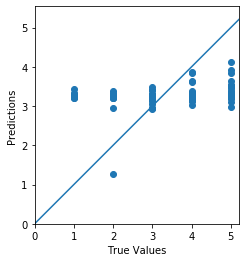

In [56]:
plt.scatter(y_valid, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


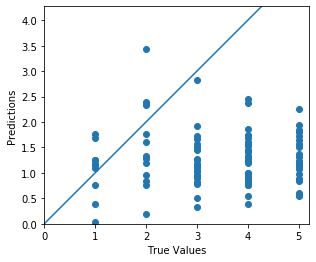

In [57]:
plt.scatter(y_valid, stepwise_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


-0.16890556244623092


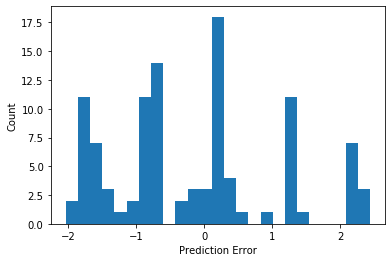

In [44]:
test_predictions = test_predictions.flatten()
error = test_predictions - y_valid
print(np.mean(error))
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
plt.savefig('./mlp_p_error.png')

-2.17915997295194


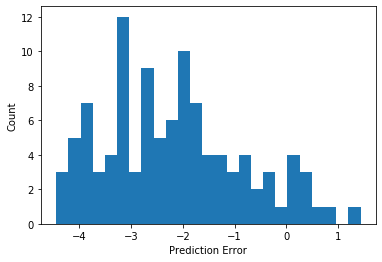

In [54]:
stepwise_predictions = np.array(stepwise_predictions)
error = stepwise_predictions - y_valid
print(np.mean(error))
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
plt.savefig('./stepwise_p_error.png')